In [1]:
%reload_ext autoreload

In [2]:
# Packages needed

#!pip install "tabulate" "pandas_summary" "imblearn" "joblib"
#!pip install fastai==0.7.0
#!pip install eli5
#!pip install ggplot
#!pip install pdp
#!pip install wandb

In [3]:
# Imports

%load_ext autoreload
%autoreload 2

%matplotlib inline
import sys
from pandas import Timestamp
import pandas as pd
from fastai.imports import *
from fastai.structured import *
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals import joblib
from sklearn.model_selection import GridSearchCV
from scipy.stats import trim_mean

from sklearn.metrics import f1_score,\
    accuracy_score, confusion_matrix,\
    precision_score, recall_score,\
    roc_curve, roc_auc_score,\
    cohen_kappa_score, mean_absolute_error,\
    precision_recall_curve, auc,\
    average_precision_score

import wandb

#import numpy as np
#import random
#from matplotlib import pyplot
#from pandas_summary import DataFrameSummary
#from IPython.display import display
#from tabulate import tabulate
#from sklearn.model_selection import GridSearchCV
#from scipy.stats.mstats import mode, gmean, hmean
#from sklearn import metrics

#set_plot_sizes(12,14,16)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


//anaconda2/envs/fastai-cpu/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
//anaconda2/envs/fastai-cpu/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [4]:
sys.path.append('../lib')
import utils
import preprocessing

In [6]:
# Load in data

PATH = "../data/"
df_raw = pd.read_csv(f'{PATH}churn.csv', low_memory=False, 
                     parse_dates=['canceldate', 'licence_registration_date', 'golive_date'])

df_raw = df_raw.drop(columns=['Username*', 'Bill Company', 'Cancellation Date',
       'Neto License Registration Date', 'Days Active', 'Neto License Status',
       'Cancellation Reason', 'Cancellation Details', 'Team Assignment',
       'Vertical', 'License Plans', 'License Plan',
       'Cancellation - Changing Platforms?', 'Cancellation - New Platform',
       'Salesperson', 'Go Live Date', 'Neto Host URL', 'golive_date', 'golive_days'])

In [7]:
df_raw.columns

Index(['licence_registration_date', 'username', 'licence_status', 'url',
       'canceldate', 'plan', 'days_active', 'account_status',
       'customer_account_status', 'nps', 'last_login_days', 'cases_total',
       'cases_open', 'cases_closed', 'cases_age_hours_total',
       'cases_age_hours_average', 'interactions_total',
       'interactions_completed', 'interactions_no_response',
       'interactions_no_onboarding', 'interactions_completed_training',
       'churn_concern_cases_total', 'churn_concern_cases_open',
       'total_churn_concern_cases_age', 'total_churn_concern_cases_age_avg',
       'churned'],
      dtype='object')

In [8]:
print(len(df_raw), df_raw.shape)

df_processed = preprocessing.prepare_data(df_raw.loc[(df_raw.licence_status != "STAGING") & (df_raw.licence_status != "PARTNER") & (df_raw.plan != "CUSTOM") & (df_raw.plan != "TRIAL")])
df_processed = df_processed.drop(columns=['licence_status'])

print(len(df_processed), df_processed.shape)

6520 (6520, 26)
Sorting dataframe by licence_registration_date ...
Defaulting last_login_days for missing values to the plans mean or platform medeian ...
  Platform last_login_days median: 7.0
  Platform last_login_days mean: 12.495808885163454


../lib/preprocessing.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['plan'][i] = "no_plan"
../lib/preprocessing.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['plan_not_set'][i] = 1


  List records that still have NaN in them ...
  0
Defaulting all NaN values with median ...
Binning last_login_days
week         3934
month+        787
month         622
fortnight     476
day           171
few_days        0
Name: last_login_categories, dtype: int64
Binning NPS data
Fixing days_active abnormal values ...
One-hot encoding customer_account_status
One-hot encoding plan
One-hot encoding nps
One-hot encoding last_login_categories
Preprocessing dates ...
Dropping feature customer_account_status_Good ...
Dropping feature last_login_days ...
Dropping feature account_status ...
Dropping feature canceldate ...
Dropping feature url ...
Dropping feature total_churn_concern_cases_age ...
Dropping features with 'interactions' in their name ...
Dropping features with 'churn_concern' in their name ...


../lib/preprocessing.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature][i] = random_replace_value(df, feature)


Convert categorical features into numbers ...
List any features that still have NaN values ...
Feature has NaN values: days_active, 123
Feature has NaN values: licence_registration_Year, 123
Feature has NaN values: licence_registration_Month, 123
Feature has NaN values: licence_registration_Week, 123
Feature has NaN values: licence_registration_Day, 123
Feature has NaN values: licence_registration_Dayofweek, 123
Feature has NaN values: licence_registration_Dayofyear, 123
5990 (5990, 88)


In [9]:
df_trn, y_trn, nas = proc_df(df_processed, 'churned')
print(len(df_trn))
print(df_trn.shape)
print(nas)

# take the output of nas, save it in training and use the same values in inference code

5990
(5990, 94)
{'days_active': 595.0, 'licence_registration_Year': 2016.0, 'licence_registration_Month': 7.0, 'licence_registration_Week': 28.0, 'licence_registration_Day': 18.0, 'licence_registration_Dayofweek': 2.0, 'licence_registration_Dayofyear': 194.0}


In [10]:
def split_vals(a,n): return a[:n], a[n:]

n_valid = 1000
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)

# save the validation data and use in inference notebook

In [11]:
X_train.shape, y_train.shape

((4990, 94), (4990,))

In [12]:
# Fix the dataset imbalance

sm = SMOTE(random_state=12, ratio = 1.0)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

In [13]:
X_train_res.shape, y_train_res.shape

((6314, 94), (6314,))

In [14]:
X_train.shape, y_train.shape

((4990, 94), (4990,))

In [ ]:
#!wandb login dda97ba4df7f598b91affe3c806891df2e043ed7

In [15]:
import time
seconds = time.time()

wandb.init(project="neto-customer-churn", name=f"customer_churn-{int(seconds)}")

columns = df_raw.columns
n_estimators = 2000
min_samples_leaf = 3
max_features = 'sqrt'
n_jobs = -1
max_depth = 10
bootstrap = False
criterion = 'entropy'
class_weight = {0: 2, 1: 1}


m = RandomForestClassifier(
    n_estimators=n_estimators,
    min_samples_leaf=min_samples_leaf, 
    max_features=max_features,
    n_jobs=n_jobs,
    max_depth=max_depth,
    bootstrap=bootstrap,
    criterion=criterion,
    class_weight=class_weight
    )

%time m.fit(X_train_res, y_train_res)
#m.fit(X_train, y_train)

y_pred = m.predict(X_valid)

wandb.config.columns = columns
wandb.config.n_estimators = n_estimators
wandb.config.min_samples_leaf = min_samples_leaf
wandb.config.max_features = max_features
wandb.config.n_jobs = n_jobs
wandb.config.max_depth = max_depth
wandb.config.bootstrap = bootstrap
wandb.config.criterion = criterion
wandb.config.class_weight = class_weight

wandb.log({'accuracy': accuracy_score(y_valid,y_pred),
           'precision': precision_score(y_valid,y_pred),
           'recall': recall_score(y_valid,y_pred),
           'cohen_kappa': cohen_kappa_score(y_valid,y_pred),
           'mean_abs_error': mean_absolute_error(y_valid,y_pred),
           'f1_score': f1_score(y_valid,y_pred)})

# you can create this file config-defaults.yaml
# sample config defaults file
#n_estimators:
#  desc: number of estimators in the forest
#  value: 2000

print(utils.uber_score(y_valid, y_pred))
utils.conf_matrix(y_valid, y_pred)

# Save to file in the current working directory
joblib_file = "./wandb/churn_model.pkl"
joblib.dump(m, joblib_file)

wandb.save("churn_model.pkl")

CPU times: user 19.7 s, sys: 1.16 s, total: 20.9 s
Wall time: 4.6 s
0.6497005988023952 0.9931350114416476 0.7855203619909502 0.763 0.5452522027446045 0.237
None
tp, fn, fp, tn
[[329 234]
 [  3 434]]


['/Users/bjh307/Code/100-days-of-code/project/wandb/run-20191104_201957-t7h85z88/churn_model.pkl']

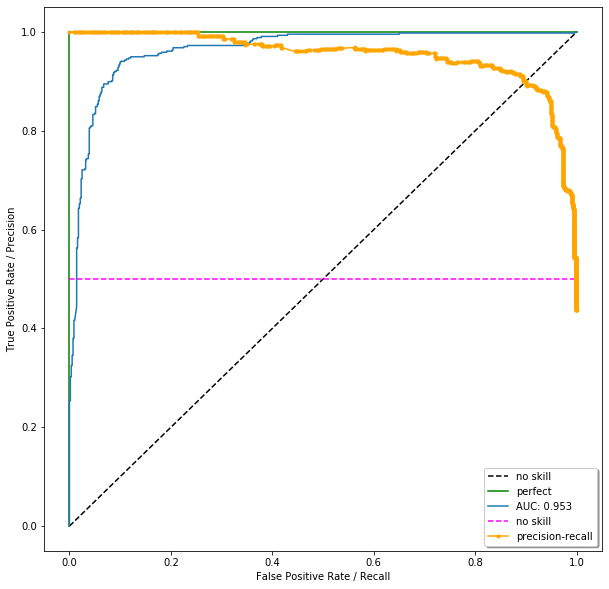

auc=0.953 ap=0.953


In [20]:
utils.plot_roc_pr(m, X_valid, y_valid)
#df_filtered.plot('golive_days', 'days_active', 'scatter', alpha=0.01, figsize=(10,8));

CPU times: user 20.5 s, sys: 3.08 s, total: 23.6 s
Wall time: 18.4 s


(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1c292ca6a0>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1c20812278>})

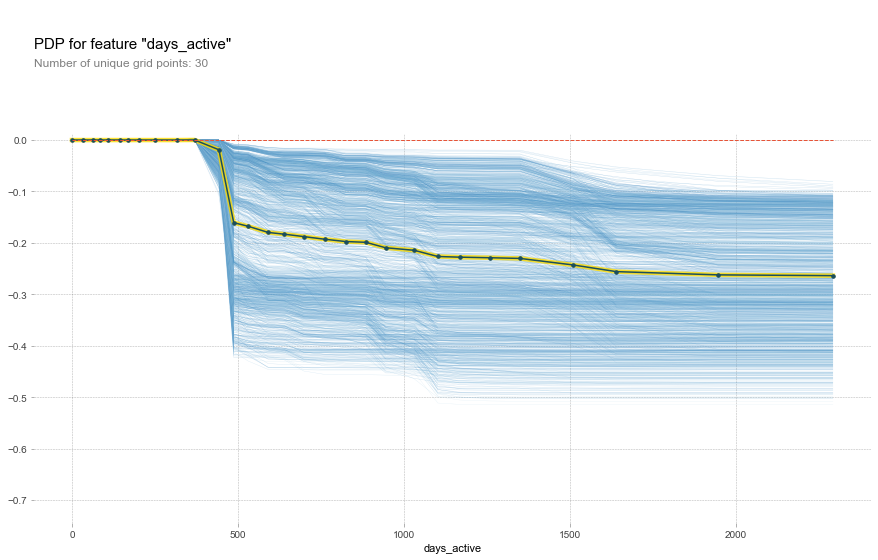

In [55]:
from pdpbox import pdp

x = get_sample(X_train, 2000)

def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, feature = feat, model_features = x.columns, num_grid_points=30)
    #p = pdp.pdp_isolate(m, x, feature = feat, num_grid_points=30)
    return pdp.pdp_plot(p, feat_name, plot_lines=True,
                        cluster=clusters is not None,
                        n_cluster_centers=clusters)

%time plot_pdp('days_active')

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1c27c09710>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1c2b550ef0>})

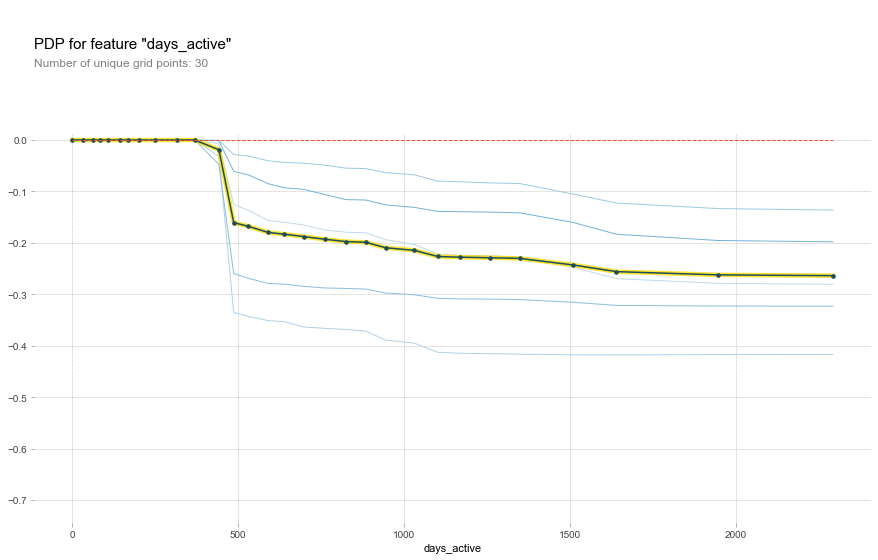

In [56]:
plot_pdp('days_active', clusters=5)

In [17]:
fi = rf_feat_importance(m, X_valid); fi[:10]

,cols,imp
1,days_active,0.149155
2,cases_total,0.108423
5,cases_age_hours_total,0.104564
6,cases_age_hours_average,0.103135
45,plan_PLAN-S-19Q1,0.095273
3,cases_open,0.057727
4,cases_closed,0.056223
69,last_login_categories_few_days,0.034110
53,plan_STANDARD,0.033902
37,plan_PLAN-L-19Q1,0.030300


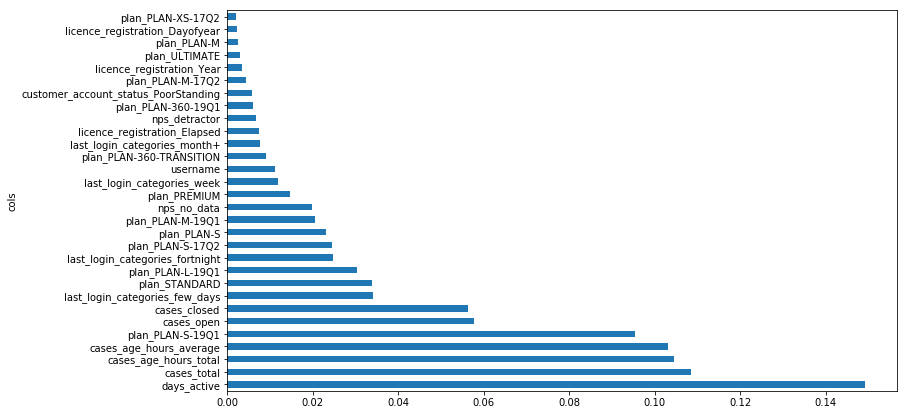

In [18]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)
plot_fi(fi[:30]);

In [19]:
to_keep = fi[fi.imp>0.01].cols; len(to_keep)
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [20]:
m.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, class_weight={0: 2, 1: 1},
                       criterion='entropy', max_depth=10, max_features='sqrt',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=3,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=2000, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

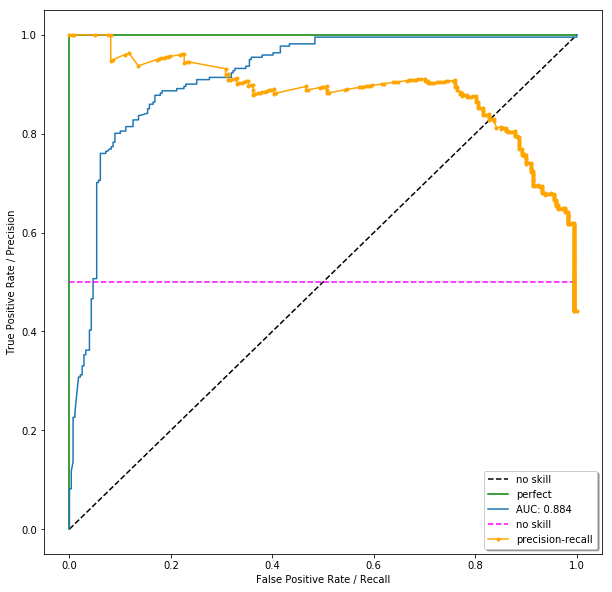

auc=0.884 ap=0.885


In [21]:
utils.plot_roc_pr(m, X_valid, y_valid)

In [22]:
# Save to file in the current working directory
#joblib_file = "churn_model.pkl"
#joblib.dump(m, joblib_file)

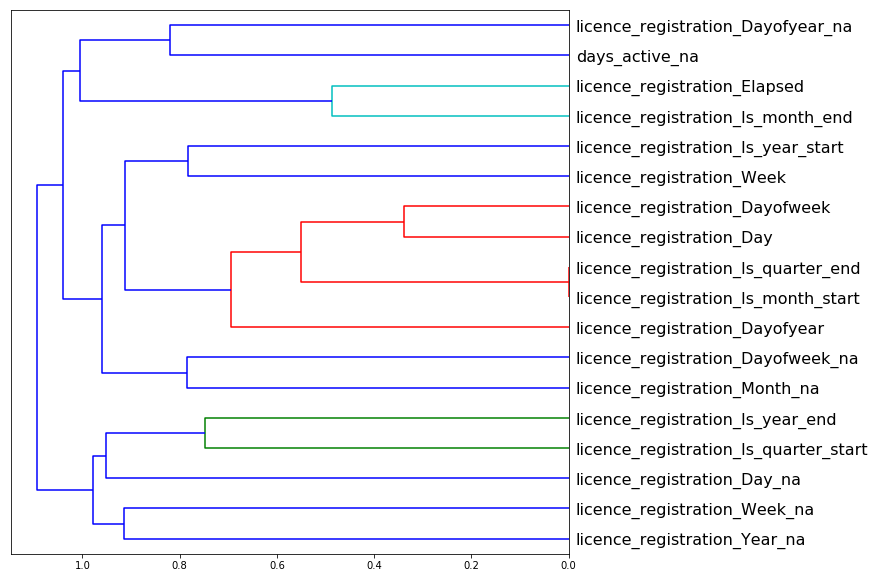

In [23]:
from scipy.cluster import hierarchy as hc

corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(10,10))
dendrogram = hc.dendrogram(z, labels=df_trn.columns, orientation='left', leaf_font_size=16)
plt.show()

In [209]:
print("precision, recall, f1_score, accuracy, cohen_kappa_score, mean abs error")

for column in df_keep.columns:
    m = RandomForestClassifier(
        n_estimators=200,
        min_samples_leaf=2, 
        max_features='sqrt',
        n_jobs=-1, 
        max_depth=3,
        bootstrap=False,
        criterion='entropy',
        class_weight={0: 4, 1: 1}
        )

    x, _ = split_vals(df_keep.drop(columns=[column]), n_trn)
    m.fit(x, y_train)
    y_pred = m.predict(x)
    print(column, utils.uber_score(y_train, y_pred))

precision, recall, f1_score, accuracy, cohen_kappa_score, mean abs error
0.9896995708154507 0.7795807978363759 0.8721633888048411 0.8660590449772142 0.735608778995085 0.1339409550227858
days_active None
0.9968253968253968 0.7430696416497633 0.8514429595196591 0.84802853180107 0.702521755174738 0.15197146819893007
cases_closed None
0.997649271274095 0.7173766058147397 0.8346116027531957 0.8333663562512383 0.6755113253815958 0.16663364374876163
cases_total None
0.997649271274095 0.7173766058147397 0.8346116027531957 0.8333663562512383 0.6755113253815958 0.16663364374876163
annual_revenue None
0.9967166979362101 0.7183908045977011 0.8349705304518664 0.8335644937586685 0.675789469176262 0.1664355062413315
cases_age_hours_total None
0.9950383400992332 0.7457741717376606 0.8525603864734299 0.8488210818307905 0.7038358069819595 0.15117891816920942
cases_open None
0.9957845433255269 0.7187288708586883 0.8348713921068133 0.8333663562512383 0.6753387771842287 0.16663364374876163
plan_PLAN-S-19Q1